# Datashading Sentinel data retrieved from Sinergise's Web Map Service

This notebook utilises the datashading procedure presented by James A. Bednar (https://anaconda.org/jbednar/landsat/notebook) on Sentinel-2 MSI data from web map services (WMS) provided by Sinergise (http://www.sinergise.com/en).


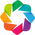

In [1]:
import requests
from PIL import Image
import io
import numpy as np
import xarray as xr
import holoviews as hv
import geoviews as gv
import datashader as ds
import cartopy.crs as ccrs
from pyproj import Proj, transform

from holoviews.operation.datashader import regrid, shade
from bokeh.tile_providers import STAMEN_TONER, CARTODBPOSITRON_RETINA

hv.extension('bokeh', width=80)

In [2]:
import pandas as pd
band_info = pd.DataFrame([
        ("01", "Coastal Aerosol",       " 20",    0.443,  "60",),
        ("02", "Blue",                  " 65",    0.490,  "10",),
        ("03", "Green",                 " 35",    0.560,  "10",),
        ("04", "Red",                   " 30",    0.665,  "10",),
        ("05", "Vegetation Red Edge",   " 15",    0.705,  "20",),
        ("06", "Vegetation Red Edge",   " 15",    0.740,  "20",),
        ("07", "Vegetation Red Edge",   " 20",    0.783,  "20",),
        ("08", "NIR",                   "115",    0.842,  "10",),
        ("8A", "Narrow NIR",            " 20",    0.865,  "20",),
        ("09", "Water vapour",          " 20",    0.945,  "60",),
        ("10", "SWIR - Cirrus",         " 20",    1.375,  "60",),
        ("11", "SWIR",                  " 90",    1.610,  "20",),
        ("12", "SWIR",                  "180",    2.190,  "20",)],
    columns=['Band', 'Name', 'Bandwidth (µm)', 'Nominal Wavelength (µm)', 'Resolution (m)'])
band_info

,Band,Name,Bandwidth (µm),Nominal Wavelength (µm),Resolution (m)
0,01,Coastal Aerosol,20,0.443,60
1,02,Blue,65,0.490,10
2,03,Green,35,0.560,10
3,04,Red,30,0.665,10
4,05,Vegetation Red Edge,15,0.705,20
5,06,Vegetation Red Edge,15,0.740,20
6,07,Vegetation Red Edge,20,0.783,20
7,08,NIR,115,0.842,10
8,8A,Narrow NIR,20,0.865,20
9,09,Water vapour,20,0.945,60


Following now are some cells to specify different parameters, such as lon/lat, resolution, layer (e.g. true color, NDVI etc.) and maximum cloud cover (called maxcc, if commented out, the max cloud cover will be ignored in the request). The data will be downloaded from the WMS from Sinergise. The data is stored on the Earth Observation Innovative Platform Testbed Poland (EO IPT Poland, www.cloudferro.com/en/eocloud/). The WMS instance has to be configurated (i.e. the user's ID is requested) by the user beforehand for which an account is required (www.sinergise.com).

In [3]:
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')

# specify central lon/lat of the image as well as dimension
lon = 12.49
lat = 41.91
xdim = 960 # number of pixels per dimension
ydim = 540 
reso = 10 # meters
# 640x360p from landsat 5 with 30 m resolution covers the same area as Sentinel 2 1920x1080p with 10 m resolution
xC,yC = transform(inProj,outProj, lon, lat)
xmin = xC - xdim*reso/2
xmax = xC + xdim*reso/2
xArr = np.arange(xmin, xmax, (xmax-xmin)/xdim)
ymin = yC - ydim*reso/2
ymax = yC + ydim*reso/2
yArr = np.arange(ymin, ymax, (ymax-ymin)/ydim)

# When using this notebook in your environment, get your own Sentinel Hub API key
# at http://www.sentinel-hub.com/create_account. This ID is for demonstration only.
ID = 'f2ba6b9a-8ba0-4f59-b05b-fd6919cf8edb'
URL = 'https://services.sentinel-hub.com/ogc/wms/'+ID

params = {'service': 'WMS',
          'REQUEST': 'GetMap',
          'styles': '',
          'format': 'image/png',
          'transparent': 'false',
          'version': '1.1.1',
          'showlogo': 'false',
          'height': ydim,
          'width': xdim,
          'maxcc': 20,
          #'time': '2017-08-12',
          'mosaickingOrder': 'None',
          'srs': 'EPSG%3A3857', 
          'bbox': str(xmin)+', '+str(ymin)+', '+str(xmax)+', '+str(ymax)
         }

After defining all the parameters, the data can be downloaded eventually. For further processing, the data is stored in a xarray.

In [4]:
imgArr = []
for b in band_info['Band']:
    params['layers'] = 'B'+b
    print(f'{b} / 12+A loading', end='\r')
    r = requests.get(URL, {**params})
    #print(r.url)
    imgTiff = None

    imgTiff = Image.open(io.BytesIO(r.content))
    imgArr.append(np.array(imgTiff))
    
print(f'all bands downloaded', end='\r') 
data = xr.DataArray(imgArr, coords=[band_info['Band'], yArr, xArr], dims=['band', 'y', 'x'])

Some image processing is done: The data above a certain threshold is cut off and the remaining data stretched on the new interval. Then the stretched arrays are put together in a holoviews RGB object and returned.

In [5]:
def combine_bands(r, g, b, x, y, lim):
    xs, ys = x, y
    r = (imageStretch(r, 0, lim))
    g = (imageStretch(g, 0, lim))
    b = (imageStretch(b, 0, lim))
    col, rows = r.shape
    return hv.RGB((xs, ys[::-1], r, g, b))

def imageStretch(image_array, low_border, high_border):
    """Linear Stretching between Min and Max Values."""
    
    image_array = image_array.astype(float)
    image_array_clip = np.clip(image_array, low_border, high_border)
    image_array_new = array_normalisation(image_array_clip)
    image_array_new_int = image_array_new.astype(float)
    
    return image_array_new_int

def array_normalisation(image_array,low=0,high=1):
    """To normalise an input array."""
    
    image_array_maxValue  = image_array.max()
    image_array_minValue  = image_array.min()
    image_array_norm = float(low) + (image_array - image_array_minValue) * (float(high) - float(low)) / (image_array_maxValue-image_array_minValue)   
    
    return image_array_norm


The upper limit of the data values (below as variable lim) is simply for a better visualization of the image. If it is not wanted, lim can be set to 255.

In [7]:
lim = 75
true_color = combine_bands(data[3], data[2], data[1], xArr, yArr, lim).relabel("True Color (R=Red, G=Green, B=Blue)")

Using the holoviews' datashader regrid function, the image is plotted on top a tile layer, provided by a WMTS.

In [8]:
%opts Overlay [width=720 height=480]
tiles = gv.WMTS(CARTODBPOSITRON_RETINA)
tiles * regrid(true_color)

:DynamicMap   []

If zoomed in, the image will be re-rasterized to show all the detail at full resolution.

Holoviews' HoloMap allows us to get spectral reflectance information for each band:

In [9]:
%%opts Curve [width=800 height=300 logx=True]

band_map = hv.HoloMap({i: hv.Image(band) for i, band in enumerate(data)})

def spectrum(x, y):
    try: 
        spectrum_vals = band_map.sample(x=x, y=y)['z']
        point = gv.Points([(x, y)], crs=ccrs.GOOGLE_MERCATOR)
        point = gv.operation.project_points(point, projection=ccrs.PlateCarree())
        label = label = 'Lon: %.3f, Lat: %.3f' % tuple(point.array()[0])
    except:
        dummy = band_map[0]
        x, y = dummy.bounds.centroid()
        point = gv.Points([(x, y)], crs=ccrs.GOOGLE_MERCATOR)
        point = gv.operation.project_points(point, projection=ccrs.PlateCarree())
        spectrum_vals = band_map.sample(x=x, y=y)['z']
        label = 'Lon: %.3f, Lat: %.3f' % tuple(point.array()[0])
    
    return hv.Curve((band_info['Nominal Wavelength (µm)'].values, spectrum_vals), label=label,
                    kdims=['Wavelength (µm)'], vdims=['Reflectance']).sort()

spectrum(x=None, y=None)

:Curve   [Wavelength (µm)]   (Reflectance)

Combining the true color image and the spectrum curve allows the user to hover over the image with the mouse and getting (processed) reflectance information in real-time.

In [10]:
%%opts Curve RGB [width=450 height=450] Curve [logx=True]

tap = hv.streams.PointerXY(source=true_color)
spectrum_curve = hv.DynamicMap(spectrum, streams=[tap]).redim.range(Reflectance=(0, 65e3))

tiles * regrid(true_color) + spectrum_curve

:Layout
   .DynamicMap.I  :DynamicMap   []
   .DynamicMap.II :DynamicMap   []